# Logistic regression

Copyright 2018 Wes Barnett

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize, fmin
%matplotlib inline

## 1 Logistic regression

In [2]:
df = pd.read_csv("ex2data1.txt", header=None, names=["exam1", "exam2", "admitted"])
df.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
X = df.drop("admitted", axis=1)
y = df["admitted"]
m = len(y)

## 1.1 Data visualization

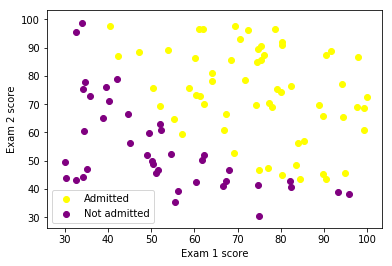

In [4]:
plt.scatter(X["exam1"][y == 1], X["exam2"][y == 1], label="Admitted", color="yellow")
plt.scatter(X["exam1"][y == 0], X["exam2"][y == 0], label="Not admitted", color="purple")
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend()
plt.show()

## 1.2 Implementation
### 1.2.1 Sigmoid function

In [5]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

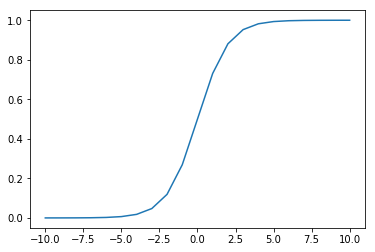

In [6]:
sigmoid_x = np.arange(-10, 11)
plt.plot(sigmoid_x, sigmoid(sigmoid_x))
plt.show()

### 1.2.2 Cost function and gradient

$J(\theta) = \frac{1}{m}\sum_{i=1}^{m} \left [ -y^{(i)}\log{(h_{\theta}(x^{(i)}))} - (1 - y^{(i)}) \log{(1 - h_{\theta}(x^{(i)}))} \right ]$

$\frac{\delta J(\theta)}{\delta \theta_{j}} = \frac{1}{m} \sum^{m}_{i=1} \left ( h_{\theta} (x^{(i)}) - y^{(i)} \right )x_{j}^{(i)}$

$h_{\theta}(x) = g(\theta^{T}x)$

$g(z) = \frac{1}{1 + e^{-z}}$

In [7]:
def costFunction(theta, X, y):
    h = np.transpose(sigmoid(np.matmul(X, theta)))
    J = np.sum(-y * np.log(h) - (1-y)*np.log(1-h))
    J /= len(y) 
    return J
    
def gradFunction(theta, X, y):
    h = sigmoid(np.matmul(X, theta))
    grad = np.matmul(h-y, X)
    grad /= len(y)  
    return grad

In [8]:
X = np.hstack((np.ones((m,1)), X.values))
X.shape

(100, 3)

In [9]:
initial_theta = np.zeros((X.shape[1]))
initial_theta

array([0., 0., 0.])

In [10]:
# Expected cost = 0.693
costFunction(initial_theta, X, y)

0.6931471805599453

In [11]:
# Expected gradient = -0.1000, -12.0092, -11.2628
gradFunction(initial_theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

In [12]:
# Expected cost = 0.218
test_theta = np.array([-24, 0.2, 0.2])
costFunction(test_theta, X, y)

0.21833019382659785

In [13]:
# Expected gradient = 0.043, 2.566, 2.647
gradFunction(test_theta, X, y)

array([0.04290299, 2.56623412, 2.64679737])

### 1.2.3 Optimizing using scipy

In [14]:
x0 = initial_theta
theta_opt = fmin(costFunction, x0, args=(X, y), xtol=1e-8)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 210
         Function evaluations: 398


In [15]:
# Expected theta: -25.161, 0.206, 0.201
theta_opt

array([-25.16133328,   0.20623171,   0.2014716 ])

### 1.2.4 Decision boundary

$y = 1$ when $h_{\theta} > 0.5$, or $z > 0$

$y = 0$ when $h_{\theta} < 0.5$, or $z < 0$

So the boundary is defined when $z = \theta^{T}X = 0$.

$\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} = 0$

To plot the line, we get $x_{2}$, which is on the y-axis, in terms of $x_{1}$, which is on the x-axis.

$x_{2} = -(\theta_{0} + \theta_{1}x_{1}) / \theta_{2}$

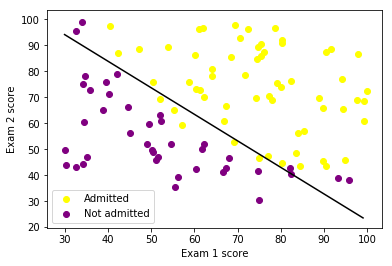

In [16]:
plt.scatter(df["exam1"][df["admitted"] == 1], df["exam2"][df["admitted"] == 1], label="Admitted", color="yellow")
plt.scatter(df["exam1"][df["admitted"] == 0], df["exam2"][df["admitted"] == 0], label="Not admitted", color="purple")
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
boundary_x = np.arange(30,100)
boundary_y = (-1./theta_opt[2])*(theta_opt[1]*boundary_x + theta_opt[0])
plt.plot(boundary_x, boundary_y, color="black")
plt.legend()
plt.show()

## 2 Regularized logistic regression

In [17]:
df = pd.read_csv("ex2data2.txt", header=None, names=["test1", "test2", "accepted"])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


### 2.1 Data visualization

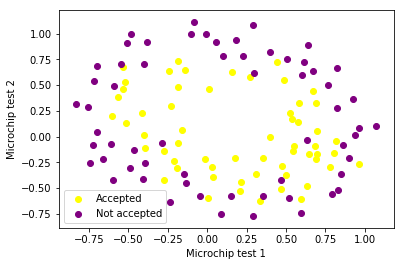

In [18]:
plt.scatter(df["test2"][df["accepted"] == 1], df["test1"][df["accepted"] == 1], label="Accepted", color="yellow")
plt.scatter(df["test1"][df["accepted"] == 0], df["test2"][df["accepted"] == 0], label="Not accepted", color="purple")
plt.xlabel("Microchip test 1")
plt.ylabel("Microchip test 2")
plt.legend()
plt.show()

In [19]:
X = df.drop("accepted", axis=1)
y = df["accepted"]
m = len(y)
X = X.values
X.shape

(118, 2)

### 2.2 Feature mapping

In [20]:
def mapFeature(X1, X2):
    # X1 and X2 must be the same size
    degree = 6
    if len(X1.shape) > 0:
        X1size = X1.shape[0]
    else:
        X1size = 1
    out = np.ones((X1size,1))
    for i in range(1,degree+1):
        for j in range(i+1):
            out = np.hstack((out, (X1**(i-j) * X2**(j)).reshape(X1size,1)))
    return out

In [21]:
X = mapFeature(X[:,0], X[:,1])
X.shape

(118, 28)

### 2.3 Cost function and gradient

$J(\theta) = \frac{1}{m}\sum_{i=1}^{m} \left [ -y^{(i)}\log{(h_{\theta}(x^{(i)}))} - (1 - y^{(i)}) \log{(1 - h_{\theta}(x^{(i)}))} \right ] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$

For $j = 0$:

$\frac{\delta J(\theta)}{\delta \theta_{j}} = \frac{1}{m} \sum^{m}_{i=1} \left ( h_{\theta} (x^{(i)} - y^{(i)} \right )x_{j}^{(i)}$

For $j \ge 1$:

$\frac{\delta J(\theta)}{\delta \theta_{j}} = \frac{1}{m} \sum^{m}_{i=1} \left ( h_{\theta} (x^{(i)} - y^{(i)} \right )x_{j}^{(i)} + \frac{\lambda}{m}\theta_{j}$

In [22]:
initial_theta = np.zeros(X.shape[1])

In [23]:
lamb = 1

In [24]:
def costFunctionReg(theta, X, y, lamb):
    h = np.transpose(sigmoid(np.matmul(X, theta)))
    J = np.sum(-y * np.log(h) - (1-y)*np.log(1-h))
    J += lamb*0.5*np.sum(theta[1:]**2)
    J /= len(y) 
    return J
    
def gradFunctionReg(theta, X, y, lamb):
    h = sigmoid(np.matmul(X, theta))
    grad = np.matmul(h-y, X)
    grad[1:] += lamb*theta[1:]
    grad /= len(y)  
    return grad

In [25]:
# Expect 0.693
costFunctionReg(initial_theta, X, y, lamb)

0.6931471805599454

In [26]:
# Expect first five values: 0.0085, 0.0188, 0.0001, 0.0503, 0.0115
gradFunctionReg(initial_theta, X, y, lamb)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

In [27]:
# Expected cost: 3.16
test_theta = np.ones(X.shape[1])
costFunctionReg(test_theta, X, y, 10)

3.16450933161501

In [28]:
# Expected first five values: 0.346, 0.1614, 0.1948, 0.2269 0.0922
gradFunctionReg(test_theta, X, y, 10)

array([0.34604507, 0.16135192, 0.19479576, 0.22686278, 0.09218568,
       0.24438558, 0.14339212, 0.10844171, 0.10231439, 0.18346846,
       0.17353003, 0.08725552, 0.11822776, 0.0858433 , 0.19994895,
       0.13522653, 0.09497527, 0.09356441, 0.09979784, 0.09140157,
       0.17485242, 0.14955442, 0.08678566, 0.09897686, 0.08531951,
       0.10190666, 0.08450198, 0.18228323])

#### 2.3.1 Learning parameters using scipy optimize

In [29]:
initial_theta = np.zeros(X.shape[1])
x0 = initial_theta
lamb = 1.
theta_opt = minimize(costFunctionReg, x0, jac=gradFunctionReg, method="BFGS", 
                     args=(X, y, lamb), options={"maxiter": 400})

In [30]:
theta_opt.x

array([ 1.27268739,  0.62557016,  1.1809665 , -2.01919822, -0.91761468,
       -1.43194199,  0.12375921, -0.36513086, -0.35703388, -0.17485805,
       -1.45843772, -0.05129676, -0.61603963, -0.2746414 , -1.19282569,
       -0.24270336, -0.20570022, -0.04499768, -0.27782709, -0.29525851,
       -0.45613294, -1.04377851,  0.02762813, -0.29265642,  0.01543393,
       -0.32759318, -0.14389199, -0.92460119])

### 2.4 Plotting the decision boundary

For this decision boundary, since it is much more complex than the linear case, we create a grid of values where we calculate $\theta^{T}X$ and plot the contour where this 0.

In [31]:
def plotDecisionBoundary(df, theta):
    plt.scatter(df["test2"][df["accepted"] == 1], df["test1"][df["accepted"] == 1], label="Accepted", color="yellow")
    plt.scatter(df["test1"][df["accepted"] == 0], df["test2"][df["accepted"] == 0], label="Not accepted", color="purple")
    plt.xlabel("Microchip test 1")
    plt.ylabel("Microchip test 2")

    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    z = np.zeros((len(u), len(v)))

    for i in range(len(u)):
        for j in range(len(v)):
            z[i, j] = np.matmul(mapFeature(u[i], u[j]), theta)

    z = np.transpose(z)
    plt.contour(u, v, z, [0])
    plt.legend()
    plt.show()

### 2.5 Tuning the regularization parameter

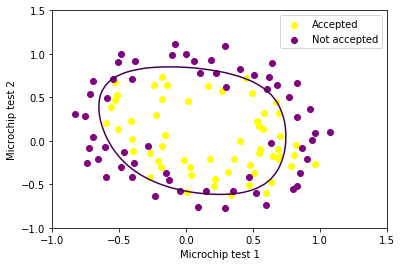

In [32]:
plotDecisionBoundary(df, theta_opt.x)

We predict a acceptance ($y=1$ or $y=0$) by calculating $h_{\theta}(x)$ and then rounding to 0 or 1 based on that value.

In [33]:
def predict(theta, X):
    return np.round(sigmoid(np.matmul(X,theta)))

In [34]:
p = predict(theta_opt.x, X)

Here we define the training accuracy to be average number of predictions that were correct.

In [35]:
# Training accuracy - should be 83.1
np.mean(p == y) * 100

83.05084745762711

In [36]:
# Overfitting by setting regularization parameter to 0
x0 = np.zeros(X.shape[1])
lamb = 0.
theta_opt = minimize(costFunctionReg, x0, jac=gradFunctionReg, method="BFGS", 
                     args=(X, y, lamb), options={"maxiter": 400})

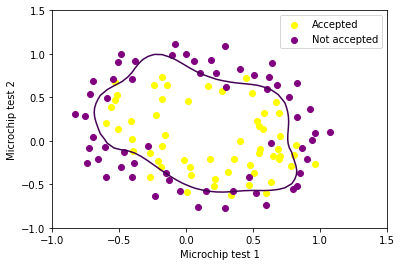

In [37]:
plotDecisionBoundary(df, theta_opt.x)

In [38]:
# Underfitting - too much regularization
x0 = np.zeros(X.shape[1])
lamb = 100.
theta_opt = minimize(costFunctionReg, x0, method="BFGS", jac=gradFunctionReg,
                     args=(X, y, lamb), options={"maxiter": 400})

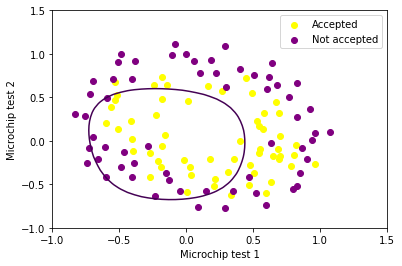

In [39]:
plotDecisionBoundary(df, theta_opt.x)

## 3 Scikit-learn

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [41]:
df = pd.read_csv("ex2data1.txt", header=None, names=['exam1', 'exam2', 'admitted'])
X = df.drop('admitted', axis=1)
y = df['admitted']

In [42]:
# Higher C means lower regularization - to compare with above we need to turn off
lr = LogisticRegression(C=1e12)
lr.fit(X,y)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [43]:
# Previous theta: -25.161, 0.206, 0.201
lr.intercept_, lr.coef_

(array([-24.95604647]), array([[0.20459008, 0.19981009]]))

In [44]:
def plot_2d_classification(classifier, X, polyfeatures=False):
    eps = X.std() / 2.
    ax = plt.gca()
    x_min, x_max = X[:,0].min() - eps, X[:,0].max() + eps
    y_min, y_max = X[:,1].min() - eps, X[:,1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)
    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.predict(X_grid)
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max, y_min, y_max),
              aspect='auto', origin='lower', alpha=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

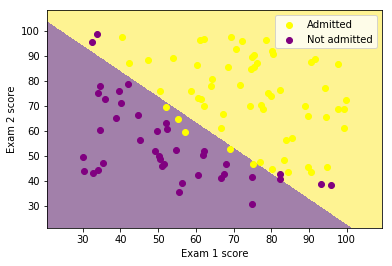

In [45]:
plot_2d_classification(lr, X.values)
plt.scatter(df["exam1"][df["admitted"] == 1], df["exam2"][df["admitted"] == 1], label="Admitted", color="yellow")
plt.scatter(df["exam1"][df["admitted"] == 0], df["exam2"][df["admitted"] == 0], label="Not admitted", color="purple")
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend()
plt.show()

### 3.1 Feature mapping and regularization

In [46]:
df = pd.read_csv("ex2data2.txt", header=None, names=["test1", "test2", "accepted"])

In [47]:
X = df.drop("accepted", axis=1)
y = df["accepted"]
pipe = Pipeline(steps=[('pf', PolynomialFeatures(degree=6)),
                       ('lr', LogisticRegression())])

In [48]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('pf', PolynomialFeatures(degree=6, include_bias=True, interaction_only=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [49]:
pipe.named_steps['lr'].coef_

array([[ 0.60181257,  0.61262932,  1.17369724, -1.94159987, -0.91652206,
        -1.34600069,  0.12538359, -0.3671774 , -0.35087379, -0.17439841,
        -1.43997026, -0.04973447, -0.6106624 , -0.27187562, -1.17708203,
        -0.24264323, -0.2065488 , -0.04393776, -0.27907087, -0.2909125 ,
        -0.46305003, -1.03941697,  0.02853522, -0.29251337,  0.01648987,
        -0.32818075, -0.14074991, -0.92845357]])

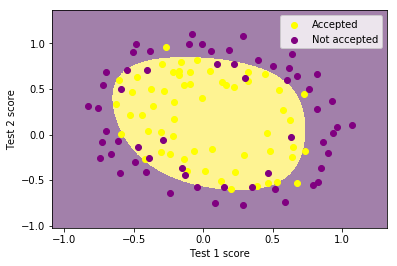

In [50]:
plot_2d_classification(pipe, X.values, polyfeatures=True)
plt.scatter(df["test1"][df["accepted"] == 1], df["test2"][df["accepted"] == 1], label="Accepted", color="yellow")
plt.scatter(df["test1"][df["accepted"] == 0], df["test2"][df["accepted"] == 0], label="Not accepted", color="purple")
plt.xlabel("Test 1 score")
plt.ylabel("Test 2 score")
plt.legend()
plt.show()

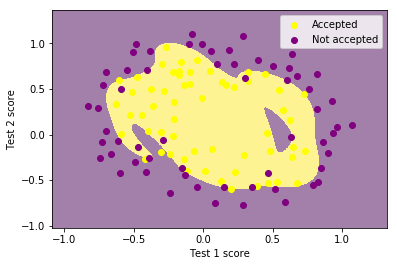

In [51]:
# Larger C values means lower regularization
pipe = Pipeline(steps=[('pf', PolynomialFeatures(degree=6)),
                       ('lr', LogisticRegression(C=1e9))])
pipe.fit(X, y)
plot_2d_classification(pipe, X.values, polyfeatures=True)
plt.scatter(df["test1"][df["accepted"] == 1], df["test2"][df["accepted"] == 1], label="Accepted", color="yellow")
plt.scatter(df["test1"][df["accepted"] == 0], df["test2"][df["accepted"] == 0], label="Not accepted", color="purple")
plt.xlabel("Test 1 score")
plt.ylabel("Test 2 score")
plt.legend()
plt.show()

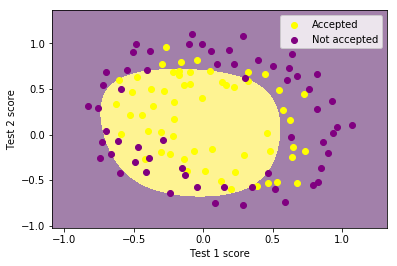

In [52]:
pipe = Pipeline(steps=[('pf', PolynomialFeatures(degree=6)),
                       ('lr', LogisticRegression(C=5e-2))])
pipe.fit(X, y)
plot_2d_classification(pipe, X.values, polyfeatures=True)
plt.scatter(df["test1"][df["accepted"] == 1], df["test2"][df["accepted"] == 1], label="Accepted", color="yellow")
plt.scatter(df["test1"][df["accepted"] == 0], df["test2"][df["accepted"] == 0], label="Not accepted", color="purple")
plt.xlabel("Test 1 score")
plt.ylabel("Test 2 score")
plt.legend()
plt.show()